<a href="https://colab.research.google.com/github/Marwanelhanafey/Tensorflow-and-PyTorch/blob/main/Advanced_Lap_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow: Data Loading and Preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize input data
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


TensorFlow: Model Definition and Training

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


TensorFlow: Evaluation

In [3]:
import time

start = time.time()
model.fit(x_train, y_train, epochs=5, batch_size=64)
end = time.time()

print(f"TensorFlow training time: {end - start:.2f} seconds")


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8323 - loss: 0.6025
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9460 - loss: 0.1855
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9602 - loss: 0.1384
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9692 - loss: 0.1043
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9736 - loss: 0.0891
TensorFlow training time: 16.85 seconds


In [4]:
# Evaluate on test set
start = time.time()
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
end = time.time()

print(f"TensorFlow Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"TensorFlow Inference Time: {end - start:.2f} seconds")


TensorFlow Test Accuracy: 96.99%
TensorFlow Inference Time: 1.55 seconds


TensorFlow: Model Conversion to TFLite

In [5]:
import tensorflow as tf
import numpy as np
import pathlib

# ── 2. Convert to TensorFlow Lite ───────────────────────────────────────────────
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]        # optional
tflite_model = converter.convert()

tflite_path = pathlib.Path("model.tflite")
tflite_path.write_bytes(tflite_model)
print(f"✓ Saved TFLite model → {tflite_path.resolve()}")




Saved artifact at '/tmp/tmpgx3nmjqd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138242407049040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138242407050000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138242407049424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138242407049808: TensorSpec(shape=(), dtype=tf.resource, name=None)
✓ Saved TFLite model → /content/model.tflite


PyTorch: Data Loading and Preprocessing

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform: normalize to [0,1]
transform = transforms.ToTensor()

# Load data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)



100%|██████████| 9.91M/9.91M [00:00<00:00, 66.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 26.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 66.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.74MB/s]


PyTorch: Model Definition

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)



PyTorch: Model Training

In [8]:
import torch.optim as optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start = time.time()
for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # sum up batch loss
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

end = time.time()
print(f"PyTorch training time: {end - start:.2f} seconds")


Epoch 1: Loss = 0.3946, Accuracy = 89.53%
Epoch 2: Loss = 0.2016, Accuracy = 94.20%
Epoch 3: Loss = 0.1488, Accuracy = 95.75%
Epoch 4: Loss = 0.1187, Accuracy = 96.56%
Epoch 5: Loss = 0.0983, Accuracy = 97.09%
PyTorch training time: 46.29 seconds


PyTorch: Evaluation

In [9]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
inference_start = time.time()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

inference_end = time.time()
accuracy = correct / total * 100

print(f"PyTorch Test Accuracy: {accuracy:.2f}%")
print(f"PyTorch Inference Time: {inference_end - inference_start:.2f} seconds")


PyTorch Test Accuracy: 96.90%
PyTorch Inference Time: 1.16 seconds


In [10]:
# Install ONNX
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 88.8 MB/s eta 0:00:00


In [11]:
dummy_input = torch.randn(1, 784)
torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=["input"], output_names=["output"])

PyTorch: Model Conversion to ONNX

In [12]:
import torch

model.eval()

# ── 2. Prepare dummy input (batch_size=1, 784 features)
dummy_input = torch.randn(1, 784)   # adjust if your net expects a different shape

# ── 3. Export to ONNX
torch.onnx.export(
    model,                    # model to export
    dummy_input,              # example input
    "model.onnx",             # file name
    input_names  = ["input"],
    output_names = ["output"],
    opset_version=14,         # good default; change only if needed
    do_constant_folding=True  # folds batch‑norm & constants for speed
)



Plotting results and outputs

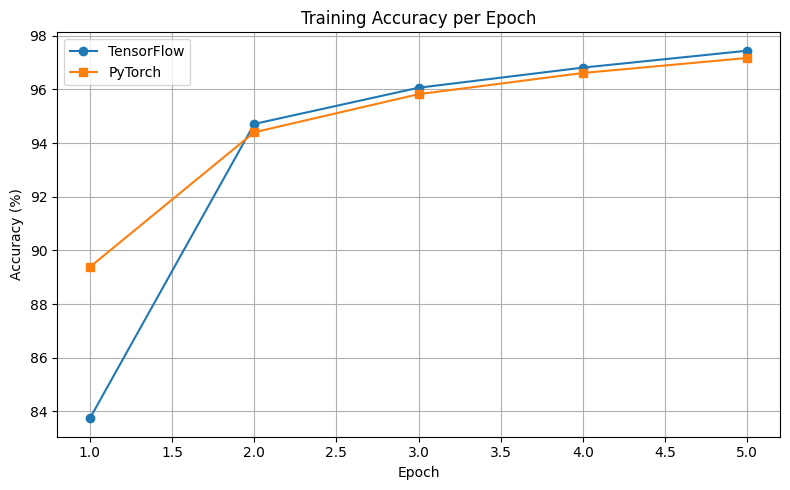

In [13]:
import matplotlib.pyplot as plt

# Example data
epochs = [1, 2, 3, 4, 5]
tf_acc = [83.74, 94.71, 96.06, 96.81, 97.44]
torch_acc = [89.38, 94.40, 95.82, 96.61, 97.17]

plt.figure(figsize=(8, 5))
plt.plot(epochs, tf_acc, marker='o', label="TensorFlow")
plt.plot(epochs, torch_acc, marker='s', label="PyTorch")
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_accuracy.png")  # This saves the file in Colab's working directory
plt.show()